In [111]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [112]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027936
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


In [113]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'NVDA']
data

,unique_id,ds,y,Z-Score
798,NVDA,2015-02-01,0.138856,0.676974
799,NVDA,2015-03-01,-0.048739,-0.732875
800,NVDA,2015-04-01,0.058909,0.076141
801,NVDA,2015-05-01,-0.003158,-0.390318
802,NVDA,2015-06-01,-0.091099,-1.051223
...,...,...,...,...
907,NVDA,2024-03-01,0.132893,0.632161
908,NVDA,2024-04-01,-0.044700,-0.702517
909,NVDA,2024-05-01,0.238128,1.423042
910,NVDA,2024-06-01,0.119427,0.530956


In [114]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027936
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


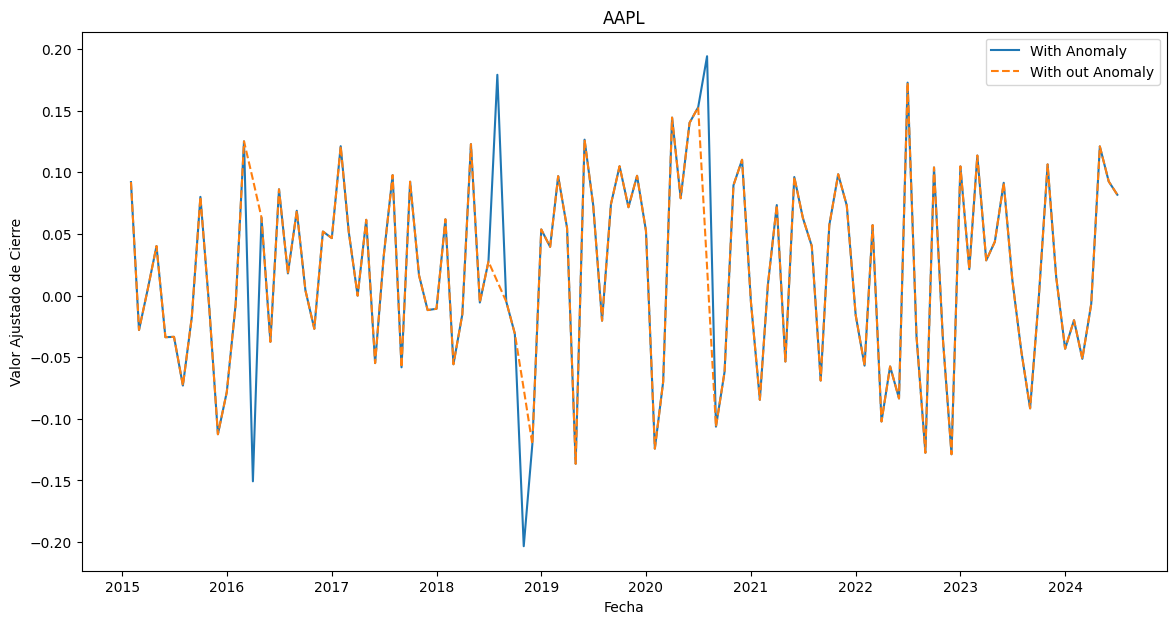

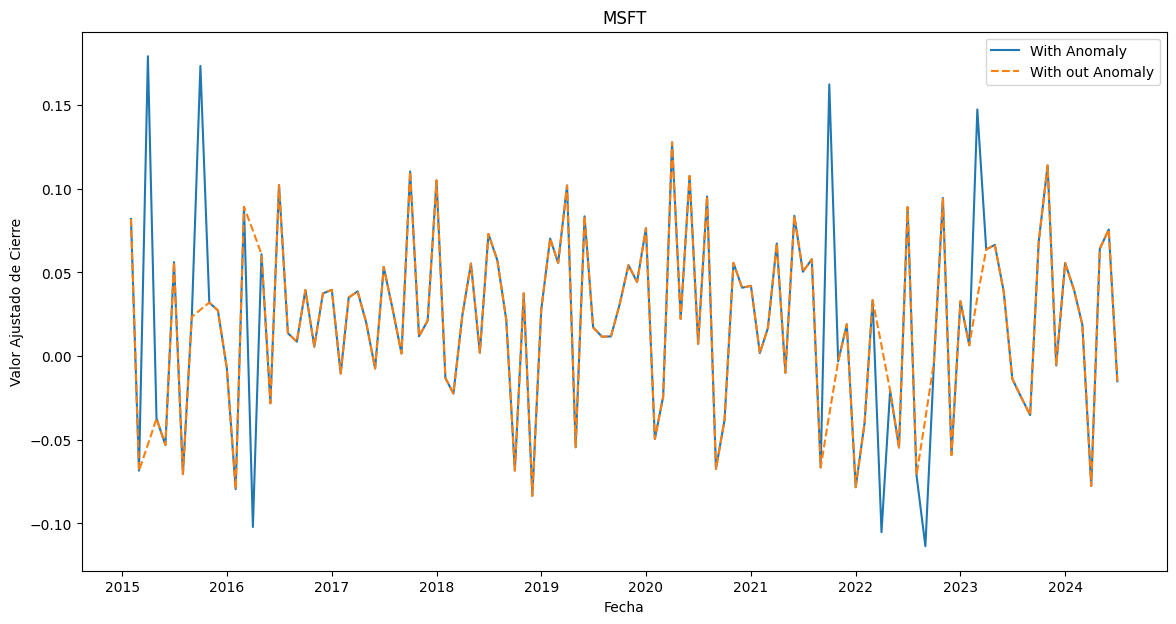

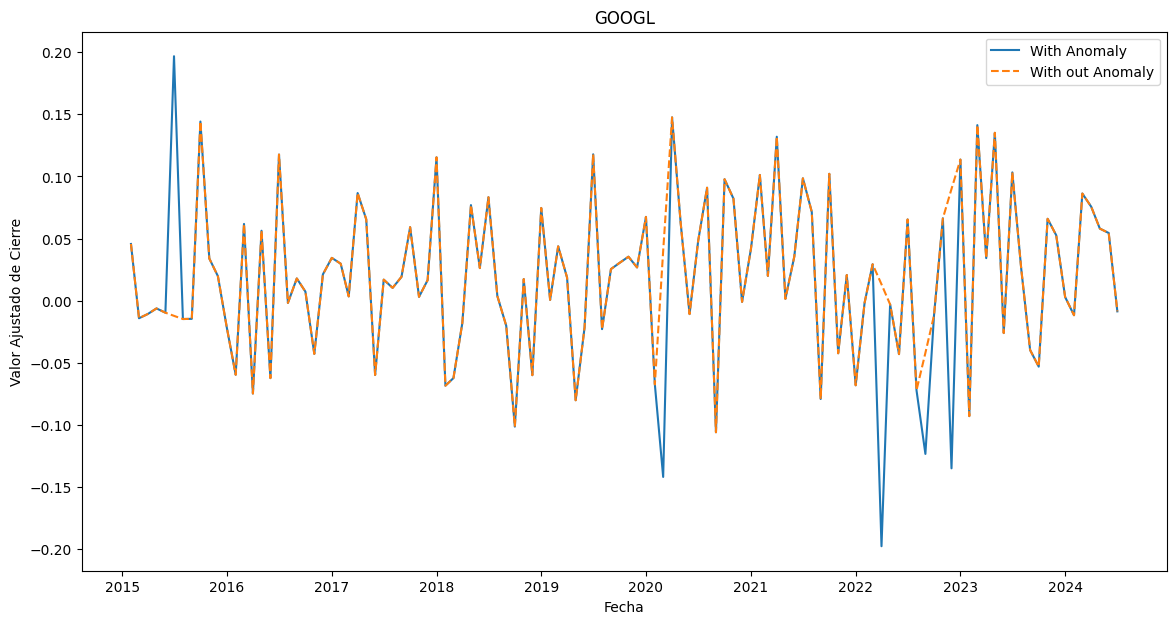

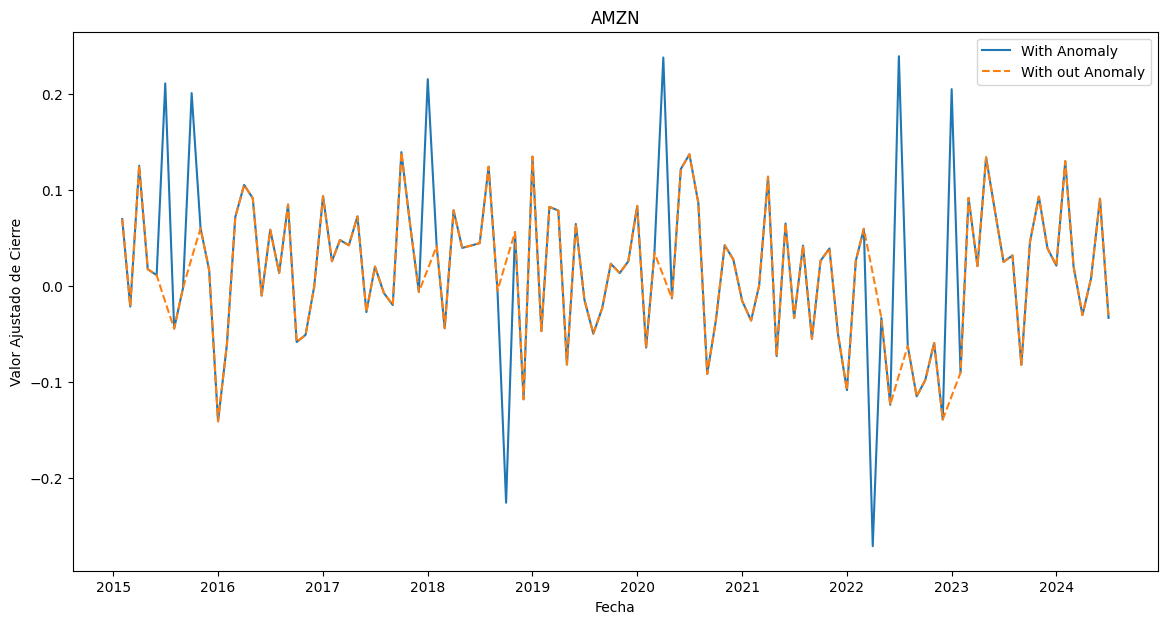

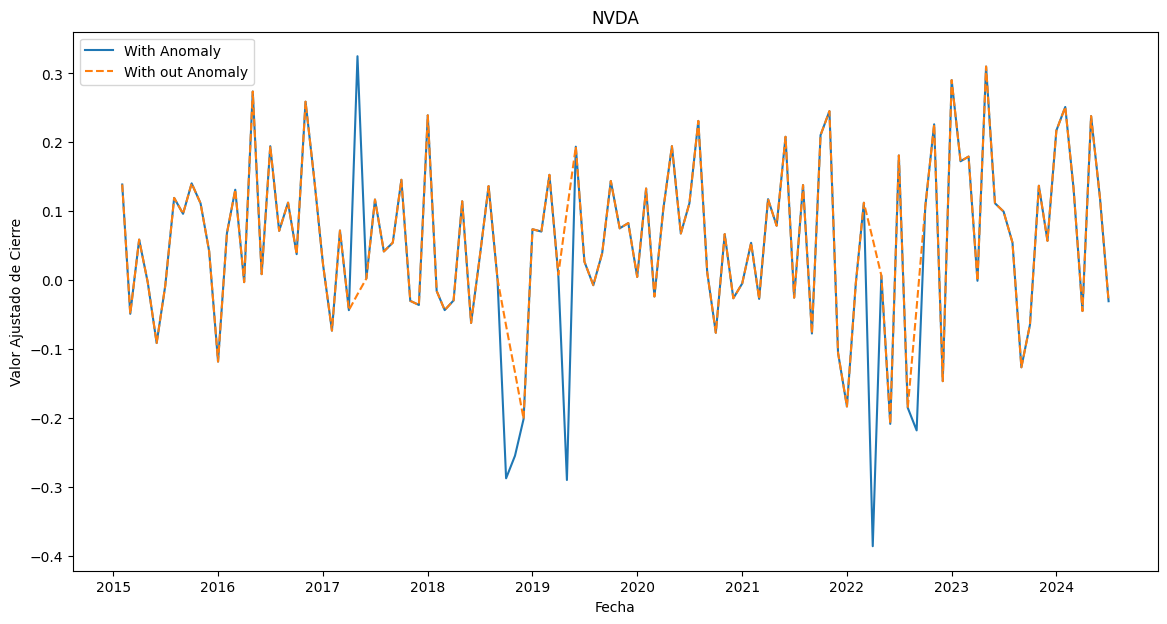

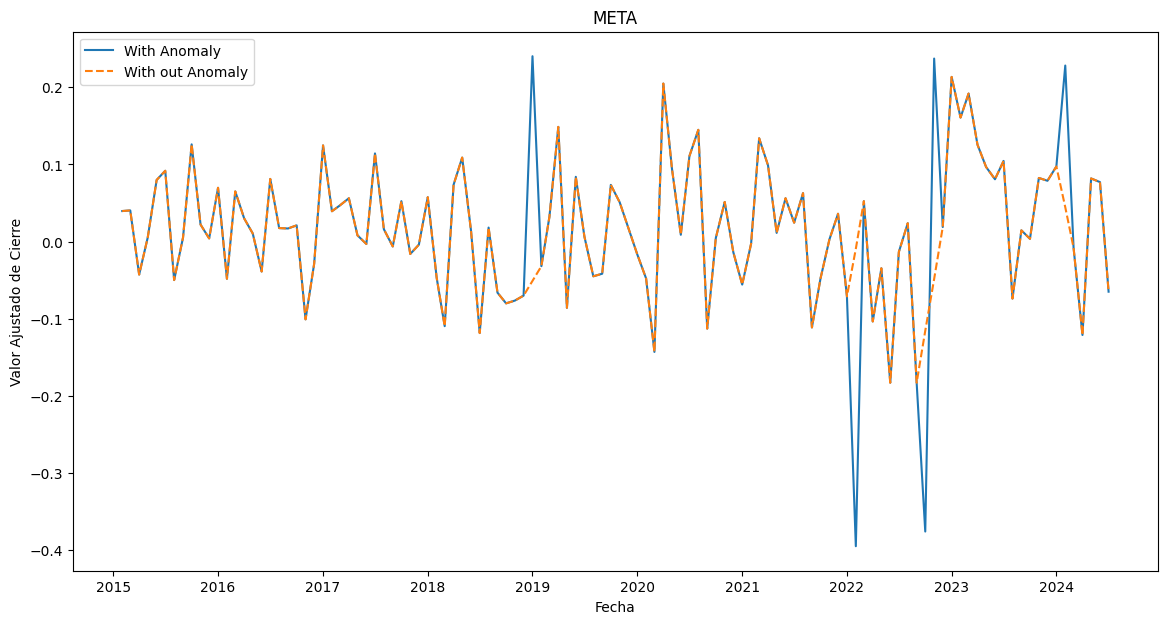

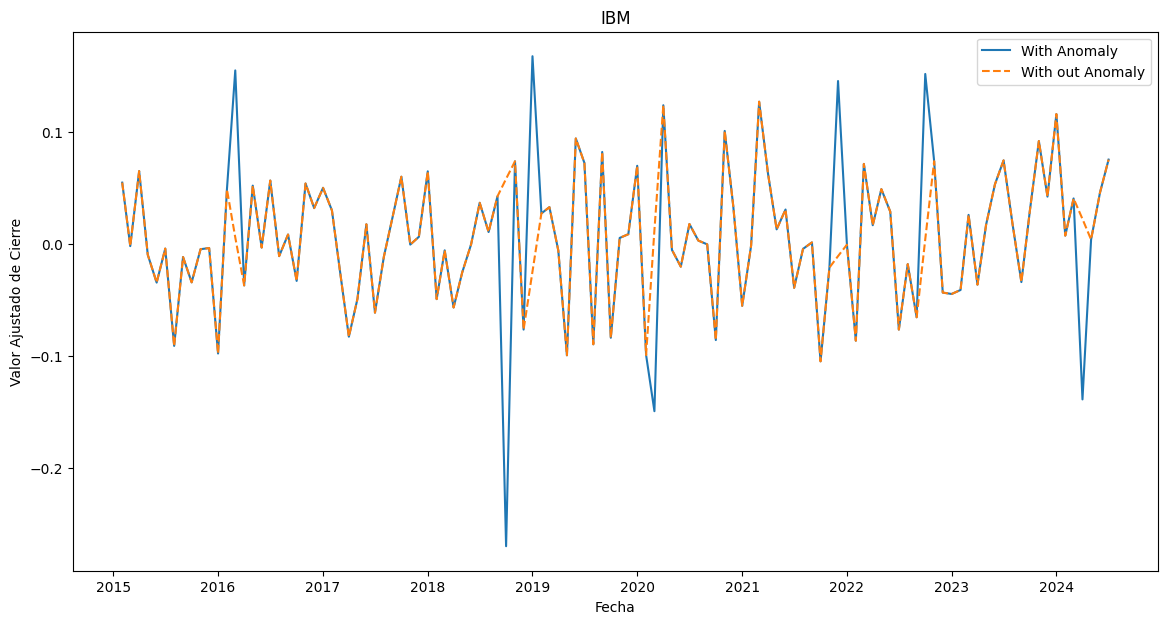

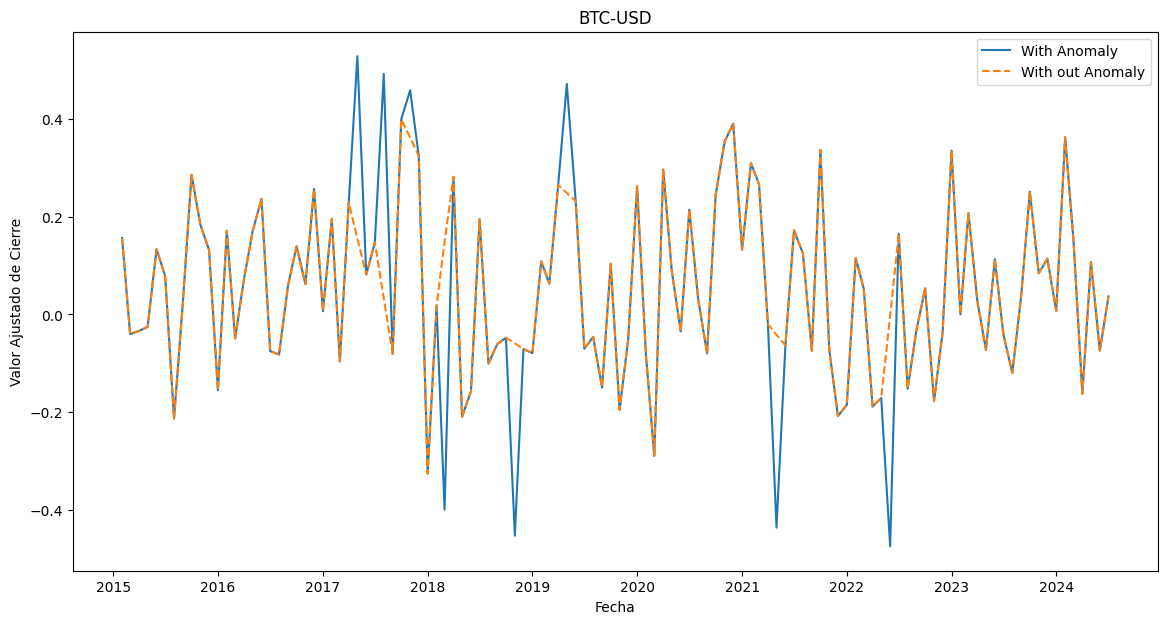

In [115]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()


In [116]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [117]:
season_length = 12 # Define season length as 12 months for monthly data
horizon = 1 # Forecast horizon is set to 1 month

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [118]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-07-31,0.081831,-0.044658,0.014795,0.019302,0.026484,0.021708
AMZN,2024-07-31,-0.033144,0.031877,0.008709,0.006936,0.017046,0.006022
BTC-USD,2024-07-31,0.036818,-0.119742,0.012294,0.055659,0.049450,-0.055265
GOOGL,2024-07-31,-0.008673,0.025662,0.003814,0.020964,0.033111,0.028954
IBM,2024-07-31,0.075321,0.018213,0.002632,0.005748,0.032113,-0.025132


In [119]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=4, step_size=horizon, level=[95])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,AutoARIMA,...,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95,CES,CES-lo-95,CES-hi-95
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-04-01,2024-03-01,-0.006729,-0.051373,-0.245915,0.143169,0.028575,-0.176690,0.233840,-0.005919,...,0.138535,0.017344,-0.128543,0.163232,0.000991,-0.124243,0.150143,0.043003,-0.149294,0.240954
AAPL,2024-05-01,2024-04-01,0.121059,-0.006729,-0.200564,0.187106,0.043647,-0.160697,0.247991,0.003583,...,0.147374,0.017220,-0.128055,0.162495,0.000219,-0.124431,0.148674,0.042943,-0.157410,0.236762
AAPL,2024-06-01,2024-05-01,0.092614,0.121059,-0.073360,0.315477,0.091525,-0.112361,0.295410,0.020022,...,0.164827,0.018032,-0.127878,0.163943,0.012303,-0.113284,0.161875,0.076532,-0.120409,0.270407
AAPL,2024-07-01,2024-06-01,0.081831,0.092614,-0.101006,0.286235,0.012704,-0.190169,0.215578,0.002467,...,0.147238,0.018721,-0.127185,0.164627,0.020334,-0.105337,0.170006,0.094149,-0.099034,0.286628
AMZN,2024-04-01,2024-03-01,-0.030280,0.020273,-0.151113,0.191659,0.020696,-0.165729,0.207122,0.022478,...,0.154457,0.017658,-0.117621,0.152937,0.020902,-0.090297,0.153337,0.066624,-0.117590,0.242314


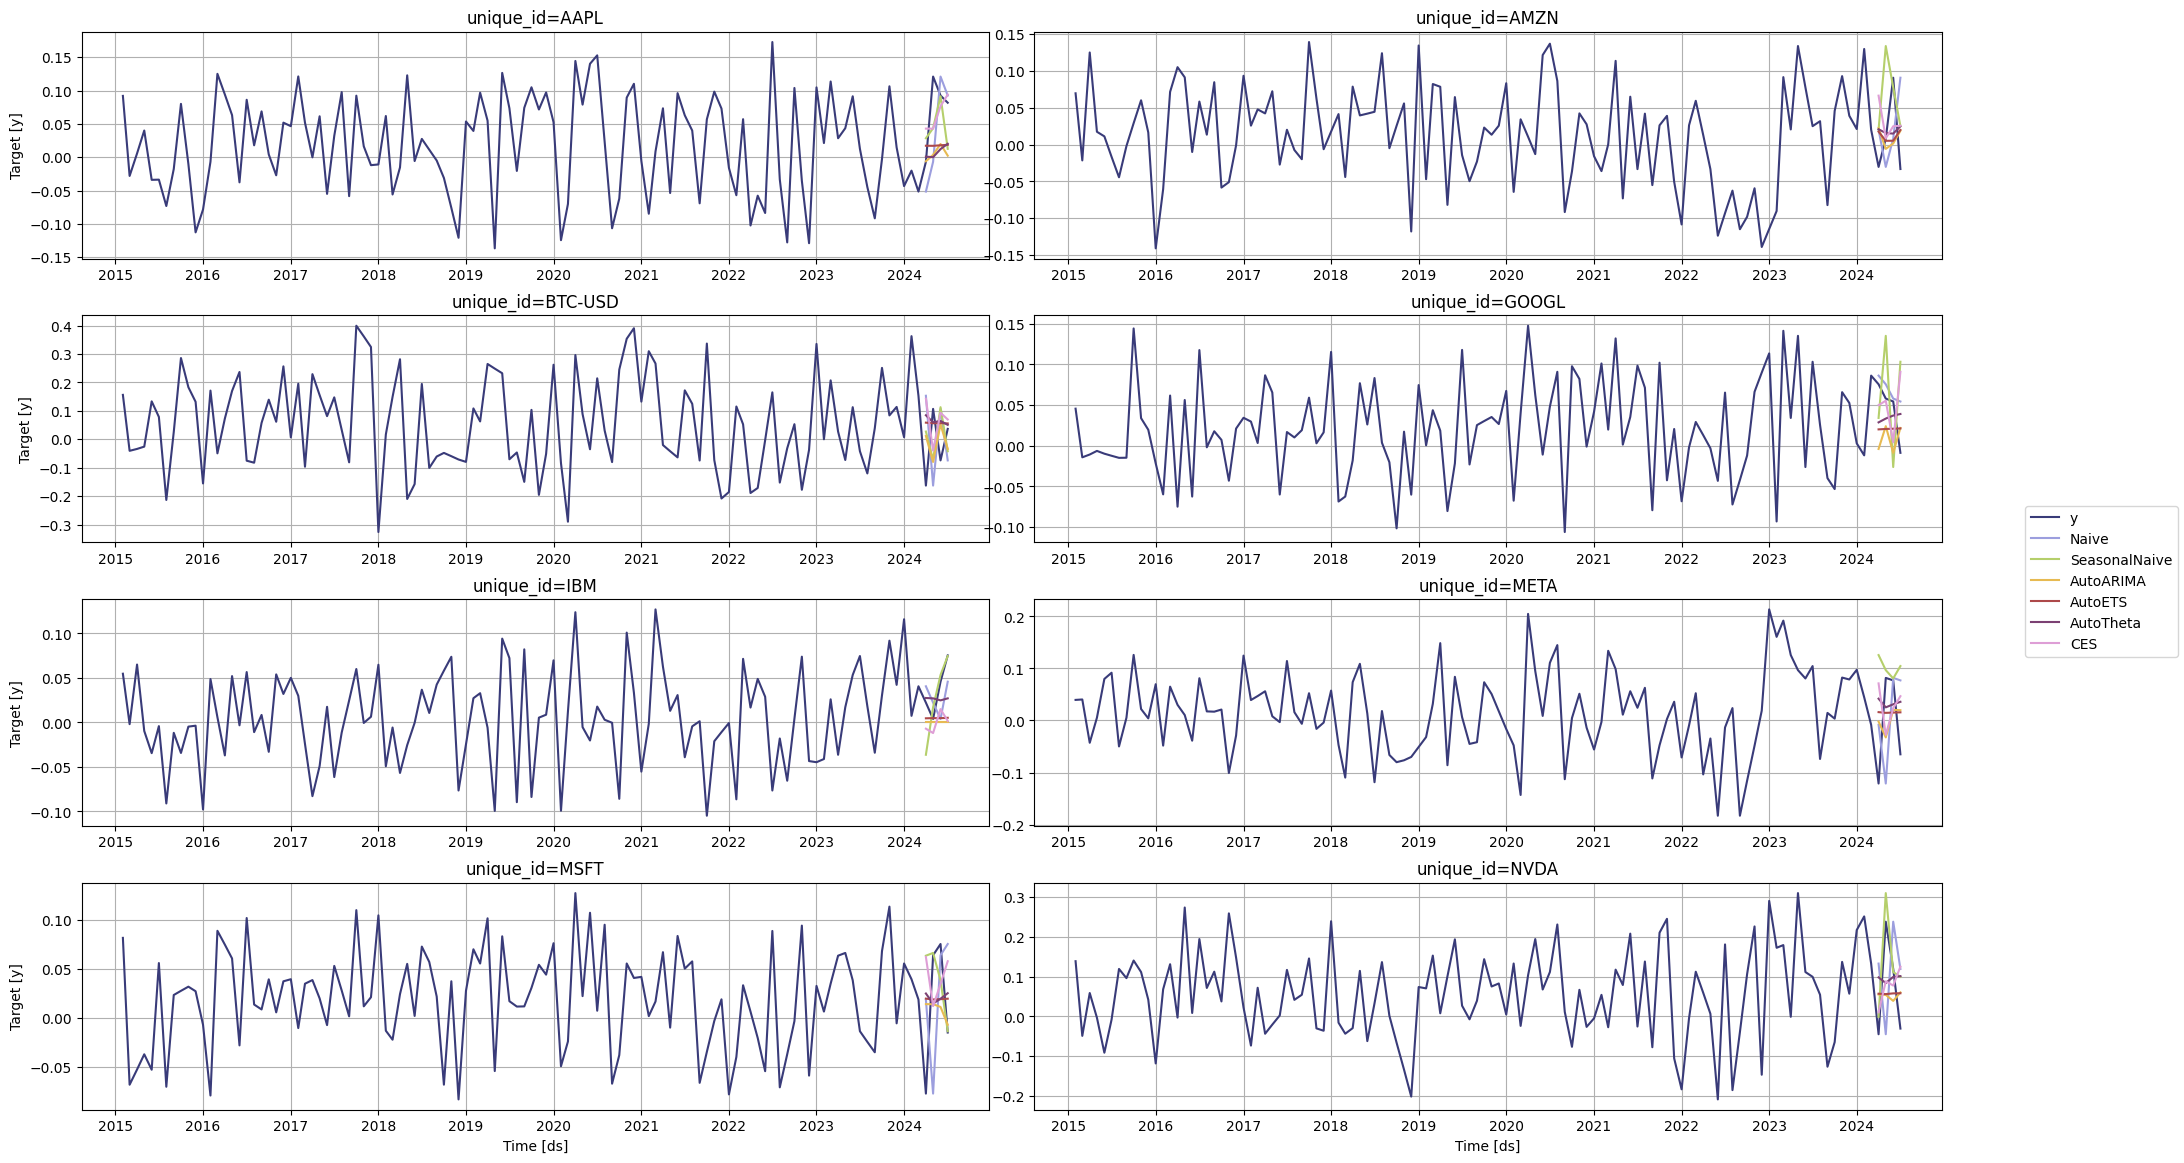

In [120]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [121]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [122]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [123]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [124]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [125]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-17 17:18:43,010 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle eda17d938507d8b9e91e1e4f0a7f7eca initialized by task ('shuffle-transfer-eda17d938507d8b9e91e1e4f0a7f7eca', 6) executed on worker tcp://127.0.0.1:52157
2024-07-17 17:18:48,545 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle eda17d938507d8b9e91e1e4f0a7f7eca deactivated due to stimulus 'task-finished-1721229528.531382'


,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,AAPL,2024-05-01,mse,0.000809,0.000001,0.00527,0.005562,0.00645,0.000259
1,AAPL,2024-05-01,mae,0.028444,0.00109,0.072592,0.074582,0.080311,0.016082
2,AAPL,2024-05-01,mape,30.712818,1.176695,78.380852,80.529663,86.715912,17.365002
3,AAPL,2024-05-01,smape,26.624287,1.183659,128.895584,134.811157,153.09462,19.016075
4,BTC-USD,2024-04-01,mse,0.072664,0.032285,0.0348,0.002538,0.002217,0.021505
...,...,...,...,...,...,...,...,...,...
15,META,2024-06-01,smape,200.0,200.0,200.0,200.0,200.0,200.0
16,NVDA,2024-06-01,mse,0.022463,0.016922,0.008263,0.007888,0.01737,0.024238
17,NVDA,2024-06-01,mae,0.149877,0.130085,0.0909,0.088817,0.131797,0.155684
18,NVDA,2024-06-01,mape,492.198425,427.199646,298.517151,291.676758,432.822998,511.269531


In [126]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  SeasonalNaive   AutoARIMA     AutoETS  \
cutoff     metric                                                      
2024-03-01 mae       0.103346       0.101004    0.080009    0.087817   
           mape    217.007019      201.48494  117.316574  158.903275   
           mse        0.01978       0.015978    0.009062    0.011729   
           smape   149.960434     183.499908  175.703018    180.8526   
2024-04-01 mae       0.137406       0.070305    0.088023    0.061239   
           mape    239.397934      286.36496  111.957359   60.808575   
           mse       0.029047       0.008205    0.012421      0.0068   
           smape   170.832382      90.377464  165.616913    93.06514   
2024-05-01 mae       0.059089       0.042236    0.074906     0.06819   
           mape      73.15213       61.64959   98.766327   88.643936   
           mse       0.007059       0.005394    0.006159    0.005457   
           smape    82.162224      63.540173  160.999527  135.765244   
2024-06-01 mae       0.090124       0.077451    0.061414    0.054953   
           mape    346.359711     307.750824  172.479187  171.883408   
           mse       0.010441        0.00907     0.00451    0.003573   
           smape   157.642578     144.555359  182.619492  167.619049   

                    AutoTheta         CES  
cutoff     metric                          
2024-03-01 mae       0.095822    0.111776  
           mape    138.461792  234.358322  
           mse       0.015439    0.020771  
           smape   163.834106  180.116699  
2024-04-01 mae       0.060437     0.06937  
           mape    135.355576  111.856071  
           mse       0.005931    0.008123  
           smape   106.161453  116.675034  
2024-05-01 mae       0.056919    0.058308  
           mape      73.22596   79.225082  
           mse       0.004732    0.005291  
           smape   101.825638   103.47612  
2024-06-01 mae       0.062823    0.077243  
           mape    219.941467  337.359741  
           mse       0.005142    0.007763  
           smape   155.836395  158.394821

<Axes: xlabel='error', ylabel='model'>

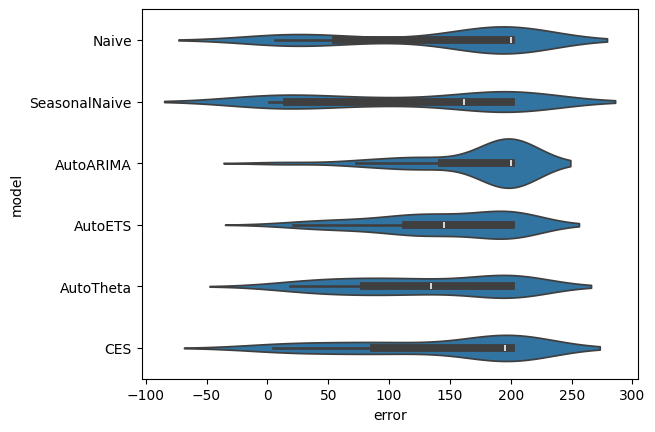

In [127]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

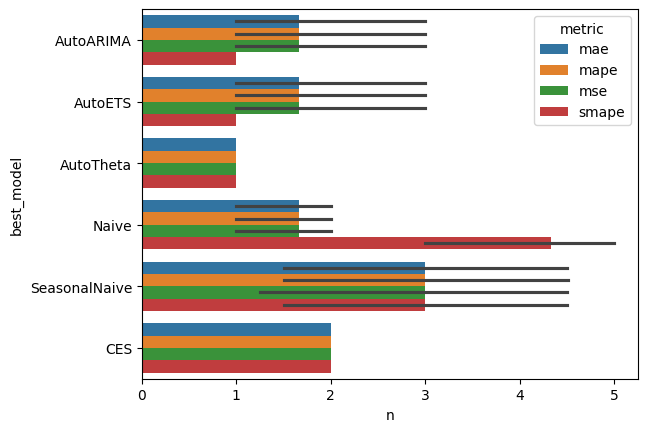

2024-07-17 18:00:51,596 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 1 memory: 53 MB fds: 38>>
Traceback (most recent call last):
  File "/Users/marcosherediapimienta/Library/Python/3.11/lib/python/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ray/thirdparty_files/psutil/__init__.py", line 2166, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


In [128]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')